<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/prova_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install -U keras-tuner

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [0]:
!rm -r my_dir

#Load data

In [0]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from tensorflow import keras

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
from kerastuner.tuners import RandomSearch, Hyperband

In [0]:
def build_model(hp):
  model = keras.models.Sequential()
#  activation = hp.Choice('activation', ['softmax', 'softplus', 'softsign',
#                              'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])
  
#  weight_init = hp.Choice('weight_init', 
#                            ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
  
  #drop_rate = hp.Choice('drop_rate', [0.0, 0.1, 0.2, 0.3,
                              #0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  
  #model.add(layers.Dense(units=(hp.Int('units', min_value=3, max_value=8, step=1)), 
                         #activation='relu', input_shape=(9,)))
  
#  for i in range(hp.Int('num_layers', 1, 3)):
#    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 
#                                              min_value=3, max_value=8, 
#                                              step=1), activation='relu'))

  model.add(layers.Dense(6, activation='relu', input_shape=(9,)))

  #model.add(layers.Dropout(rate=drop_rate))

  model.add(layers.Dense(3, activation='softmax'))
  
  #sgd_1 = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
 
  #optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  momentum = hp.Choice('momentum', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  
  model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), 
                loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

##Prova Train Test Split

In [0]:
#from sklearn.model_selection import train_test_split


In [0]:
#X_train, X_val, y_train, y_val = train_test_split(train_data_stand_pca, train_labels_dec,
#                                                    stratify=train_labels_dec,
#                                                    test_size=0.20,
#                                                    random_state=30)


In [0]:
#y_train.count(2)

con il parametro stratify si conservano le proporzioni dei label, però è meglio fare anche il K-Fold

##Stratifield K-fold

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

3

In [0]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   4   5   8   9  11  12  14  15  16  17  19  20  22  23  24  25
  27  29  30  33  34  36  37  38  39  40  41  42  44  45  46  48  51  52
  53  56  57  58  59  60  62  63  65  66  67  69  72  76  77  78  79  80
  81  83  84  85  87  88  89  90  92  96  97  98 100 101 102 103 104 105
 107 109 110 111 113 115 117 120 121 122 124 125 127 128] TEST: [  2   3   6   7  10  13  18  21  26  28  31  32  35  43  47  49  50  54
  55  61  64  68  70  71  73  74  75  82  86  91  93  94  95  99 106 108
 112 114 116 118 119 123 126 129 130]
TRAIN: [  2   3   5   6   7   8   9  10  11  12  13  18  20  21  25  26  27  28
  29  30  31  32  34  35  36  38  39  43  44  45  46  47  48  49  50  53
  54  55  57  58  61  63  64  65  66  68  70  71  73  74  75  76  78  82
  84  85  86  87  90  91  92  93  94  95  96  99 100 101 102 105 106 108
 109 111 112 114 115 116 118 119 122 123 124 125 126 127 129 130] TEST: [  0   1   4  14  15  16  17  19  22  23  24  33  37  40  41  42  51  52
  56  59 

In [0]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

#Keras tuner RandomSearch

In [0]:
num_epochs = 20
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=40, 
                       executions_per_trial=5, directory='/content/my_dir', project_name='RandomSearch')
  
  tuner.search_space_summary()

  tuner.search(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  


Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.4893 - accuracy: 0.5116 - val_loss: 1.2665 - val_accuracy: 0.4889
Epoch 2/20
86/86 [==============================] - 0s 461us/sample - loss: 1.4868 - accuracy: 0.5116 - val_loss: 1.2648 - val_accuracy: 0.4889
Epoch 3/20
86/86 [==============================] - 0s 446us/sample - loss: 1.4843 - accuracy: 0.5116 - val_loss: 1.2630 - val_accuracy: 0.4889
Epoch 4/20
86/86 [==============================] - 0s 448us/sample - loss: 1.4819 - accuracy: 0.5116 - val_loss: 1.2612 - val_accuracy: 0.4889
Epoch 5/20
86/86 [==============================] - 0s 444us/sample - loss: 1.4792 - accuracy: 0.5116 - val_loss: 1.2595 - val_accuracy: 0.4889
Epoch 6/20
86/86 [==============================] - 0s 515us/sample - loss: 1.4768 - accuracy: 0.5116 - val_loss: 1.2578 - val_accuracy: 0.5111
Epoch 7/20
86/86 [==============================] - 0s 426us/sample - loss: 1.4744 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 2.3687 - accuracy: 0.1977 - val_loss: 2.1064 - val_accuracy: 0.2667
Epoch 2/20
86/86 [==============================] - 0s 462us/sample - loss: 2.2225 - accuracy: 0.1860 - val_loss: 1.9978 - val_accuracy: 0.2667
Epoch 3/20
86/86 [==============================] - 0s 487us/sample - loss: 2.0934 - accuracy: 0.1860 - val_loss: 1.8956 - val_accuracy: 0.2667
Epoch 4/20
86/86 [==============================] - 0s 466us/sample - loss: 1.9785 - accuracy: 0.1977 - val_loss: 1.8028 - val_accuracy: 0.2667
Epoch 5/20
86/86 [==============================] - 0s 475us/sample - loss: 1.8727 - accuracy: 0.2093 - val_loss: 1.7173 - val_accuracy: 0.2667
Epoch 6/20
86/86 [==============================] - 0s 563us/sample - loss: 1.7751 - accuracy: 0.2209 - val_loss: 1.6423 - val_accuracy: 0.2889
Epoch 7/20
86/86 [==============================] - 0s 480us/sample - loss: 1.6918 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 2.6493 - accuracy: 0.4070 - val_loss: 2.2190 - val_accuracy: 0.4444
Epoch 2/20
86/86 [==============================] - 0s 441us/sample - loss: 1.9241 - accuracy: 0.4302 - val_loss: 1.9466 - val_accuracy: 0.4444
Epoch 3/20
86/86 [==============================] - 0s 439us/sample - loss: 1.5773 - accuracy: 0.3953 - val_loss: 1.7566 - val_accuracy: 0.4000
Epoch 4/20
86/86 [==============================] - 0s 489us/sample - loss: 1.3841 - accuracy: 0.4186 - val_loss: 1.6286 - val_accuracy: 0.3778
Epoch 5/20
86/86 [==============================] - 0s 522us/sample - loss: 1.2684 - accuracy: 0.4535 - val_loss: 1.5482 - val_accuracy: 0.3556
Epoch 6/20
86/86 [==============================] - 0s 498us/sample - loss: 1.1925 - accuracy: 0.4884 - val_loss: 1.4716 - val_accuracy: 0.3778
Epoch 7/20
86/86 [==============================] - 0s 436us/sample - loss: 1.1208 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 2.6362 - accuracy: 0.3721 - val_loss: 2.8376 - val_accuracy: 0.3778
Epoch 2/20
86/86 [==============================] - 0s 452us/sample - loss: 2.5933 - accuracy: 0.3721 - val_loss: 2.8096 - val_accuracy: 0.3778
Epoch 3/20
86/86 [==============================] - 0s 447us/sample - loss: 2.5490 - accuracy: 0.3721 - val_loss: 2.7803 - val_accuracy: 0.3778
Epoch 4/20
86/86 [==============================] - 0s 435us/sample - loss: 2.5019 - accuracy: 0.3721 - val_loss: 2.7543 - val_accuracy: 0.3778
Epoch 5/20
86/86 [==============================] - 0s 459us/sample - loss: 2.4592 - accuracy: 0.3721 - val_loss: 2.7240 - val_accuracy: 0.3778
Epoch 6/20
86/86 [==============================] - 0s 519us/sample - loss: 2.4154 - accuracy: 0.3721 - val_loss: 2.6971 - val_accuracy: 0.3778
Epoch 7/20
86/86 [==============================] - 0s 546us/sample - loss: 2.3755 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.8639 - accuracy: 0.3605 - val_loss: 1.7211 - val_accuracy: 0.3778
Epoch 2/20
86/86 [==============================] - 0s 441us/sample - loss: 1.7398 - accuracy: 0.3605 - val_loss: 1.6742 - val_accuracy: 0.3556
Epoch 3/20
86/86 [==============================] - 0s 457us/sample - loss: 1.6386 - accuracy: 0.3837 - val_loss: 1.6364 - val_accuracy: 0.3556
Epoch 4/20
86/86 [==============================] - 0s 468us/sample - loss: 1.5566 - accuracy: 0.3721 - val_loss: 1.6096 - val_accuracy: 0.3778
Epoch 5/20
86/86 [==============================] - 0s 426us/sample - loss: 1.4933 - accuracy: 0.3721 - val_loss: 1.5892 - val_accuracy: 0.3556
Epoch 6/20
86/86 [==============================] - 0s 448us/sample - loss: 1.4444 - accuracy: 0.3953 - val_loss: 1.5715 - val_accuracy: 0.3556
Epoch 7/20
86/86 [==============================] - 0s 415us/sample - loss: 1.4052 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 2.9642 - accuracy: 0.2907 - val_loss: 1.8988 - val_accuracy: 0.3333
Epoch 2/20
86/86 [==============================] - 0s 540us/sample - loss: 1.8986 - accuracy: 0.3605 - val_loss: 1.4280 - val_accuracy: 0.3778
Epoch 3/20
86/86 [==============================] - 0s 489us/sample - loss: 1.4499 - accuracy: 0.4186 - val_loss: 1.2219 - val_accuracy: 0.4222
Epoch 4/20
86/86 [==============================] - 0s 454us/sample - loss: 1.2679 - accuracy: 0.4535 - val_loss: 1.1365 - val_accuracy: 0.4222
Epoch 5/20
86/86 [==============================] - 0s 451us/sample - loss: 1.1419 - accuracy: 0.4535 - val_loss: 1.0681 - val_accuracy: 0.4222
Epoch 6/20
86/86 [==============================] - 0s 543us/sample - loss: 1.0442 - accuracy: 0.4884 - val_loss: 1.0396 - val_accuracy: 0.4444
Epoch 7/20
86/86 [==============================] - 0s 560us/sample - loss: 0.9924 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.8361 - accuracy: 0.4302 - val_loss: 1.3278 - val_accuracy: 0.4444
Epoch 2/20
86/86 [==============================] - 0s 534us/sample - loss: 1.3367 - accuracy: 0.4070 - val_loss: 1.1417 - val_accuracy: 0.5111
Epoch 3/20
86/86 [==============================] - 0s 477us/sample - loss: 1.1766 - accuracy: 0.4884 - val_loss: 1.1058 - val_accuracy: 0.4000
Epoch 4/20
86/86 [==============================] - 0s 447us/sample - loss: 1.1126 - accuracy: 0.5233 - val_loss: 1.0865 - val_accuracy: 0.4000
Epoch 5/20
86/86 [==============================] - 0s 438us/sample - loss: 1.0732 - accuracy: 0.5465 - val_loss: 1.0779 - val_accuracy: 0.4000
Epoch 6/20
86/86 [==============================] - 0s 445us/sample - loss: 1.0419 - accuracy: 0.5698 - val_loss: 1.0653 - val_accuracy: 0.4000
Epoch 7/20
86/86 [==============================] - 0s 429us/sample - loss: 1.0197 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 4.0531 - accuracy: 0.1163 - val_loss: 3.3584 - val_accuracy: 0.1556
Epoch 2/20
86/86 [==============================] - 0s 489us/sample - loss: 3.7760 - accuracy: 0.1047 - val_loss: 3.1846 - val_accuracy: 0.2222
Epoch 3/20
86/86 [==============================] - 0s 470us/sample - loss: 3.5187 - accuracy: 0.1279 - val_loss: 3.0219 - val_accuracy: 0.2444
Epoch 4/20
86/86 [==============================] - 0s 432us/sample - loss: 3.2854 - accuracy: 0.1512 - val_loss: 2.8732 - val_accuracy: 0.2444
Epoch 5/20
86/86 [==============================] - 0s 376us/sample - loss: 3.0865 - accuracy: 0.1512 - val_loss: 2.7369 - val_accuracy: 0.2444
Epoch 6/20
86/86 [==============================] - 0s 381us/sample - loss: 2.9089 - accuracy: 0.1628 - val_loss: 2.6116 - val_accuracy: 0.2444
Epoch 7/20
86/86 [==============================] - 0s 402us/sample - loss: 2.7533 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 3.0079 - accuracy: 0.2791 - val_loss: 2.5526 - val_accuracy: 0.4000
Epoch 2/20
86/86 [==============================] - 0s 471us/sample - loss: 2.9754 - accuracy: 0.2791 - val_loss: 2.5319 - val_accuracy: 0.4000
Epoch 3/20
86/86 [==============================] - 0s 497us/sample - loss: 2.9422 - accuracy: 0.2791 - val_loss: 2.5111 - val_accuracy: 0.4000
Epoch 4/20
86/86 [==============================] - 0s 414us/sample - loss: 2.9091 - accuracy: 0.2791 - val_loss: 2.4914 - val_accuracy: 0.4000
Epoch 5/20
86/86 [==============================] - 0s 465us/sample - loss: 2.8770 - accuracy: 0.2791 - val_loss: 2.4717 - val_accuracy: 0.4000
Epoch 6/20
86/86 [==============================] - 0s 453us/sample - loss: 2.8461 - accuracy: 0.3023 - val_loss: 2.4517 - val_accuracy: 0.4000
Epoch 7/20
86/86 [==============================] - 0s 493us/sample - loss: 2.8149 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 5ms/sample - loss: 1.8345 - accuracy: 0.5349 - val_loss: 1.6241 - val_accuracy: 0.4000
Epoch 2/20
86/86 [==============================] - 0s 730us/sample - loss: 1.3958 - accuracy: 0.5698 - val_loss: 1.4131 - val_accuracy: 0.4667
Epoch 3/20
86/86 [==============================] - 0s 611us/sample - loss: 1.1919 - accuracy: 0.5930 - val_loss: 1.3097 - val_accuracy: 0.4444
Epoch 4/20
86/86 [==============================] - 0s 722us/sample - loss: 1.0911 - accuracy: 0.5814 - val_loss: 1.2490 - val_accuracy: 0.4889
Epoch 5/20
86/86 [==============================] - 0s 551us/sample - loss: 1.0229 - accuracy: 0.5814 - val_loss: 1.2123 - val_accuracy: 0.4889
Epoch 6/20
86/86 [==============================] - 0s 602us/sample - loss: 0.9831 - accuracy: 0.6163 - val_loss: 1.1914 - val_accuracy: 0.5111
Epoch 7/20
86/86 [==============================] - 0s 576us/sample - loss: 0.9519 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.8107 - accuracy: 0.3837 - val_loss: 1.6551 - val_accuracy: 0.4444
Epoch 2/20
86/86 [==============================] - 0s 469us/sample - loss: 1.7475 - accuracy: 0.3837 - val_loss: 1.6152 - val_accuracy: 0.4444
Epoch 3/20
86/86 [==============================] - 0s 442us/sample - loss: 1.6917 - accuracy: 0.3953 - val_loss: 1.5786 - val_accuracy: 0.4444
Epoch 4/20
86/86 [==============================] - 0s 415us/sample - loss: 1.6417 - accuracy: 0.4186 - val_loss: 1.5432 - val_accuracy: 0.4444
Epoch 5/20
86/86 [==============================] - 0s 438us/sample - loss: 1.5944 - accuracy: 0.4302 - val_loss: 1.5103 - val_accuracy: 0.4444
Epoch 6/20
86/86 [==============================] - 0s 454us/sample - loss: 1.5518 - accuracy: 0.3953 - val_loss: 1.4824 - val_accuracy: 0.4444
Epoch 7/20
86/86 [==============================] - 0s 463us/sample - loss: 1.5093 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 3.0525 - accuracy: 0.5465 - val_loss: 3.3654 - val_accuracy: 0.3556
Epoch 2/20
86/86 [==============================] - 0s 479us/sample - loss: 2.6905 - accuracy: 0.5349 - val_loss: 2.8698 - val_accuracy: 0.3556
Epoch 3/20
86/86 [==============================] - 0s 446us/sample - loss: 2.3285 - accuracy: 0.5233 - val_loss: 2.5182 - val_accuracy: 0.3556
Epoch 4/20
86/86 [==============================] - 0s 449us/sample - loss: 2.0600 - accuracy: 0.5116 - val_loss: 2.1982 - val_accuracy: 0.3556
Epoch 5/20
86/86 [==============================] - 0s 450us/sample - loss: 1.8094 - accuracy: 0.5233 - val_loss: 1.9914 - val_accuracy: 0.3556
Epoch 6/20
86/86 [==============================] - 0s 528us/sample - loss: 1.6373 - accuracy: 0.5233 - val_loss: 1.7956 - val_accuracy: 0.3778
Epoch 7/20
86/86 [==============================] - 0s 522us/sample - loss: 1.4971 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.7808 - accuracy: 0.5000 - val_loss: 2.1630 - val_accuracy: 0.4444
Epoch 2/20
86/86 [==============================] - 0s 458us/sample - loss: 1.7769 - accuracy: 0.5000 - val_loss: 2.1582 - val_accuracy: 0.4444
Epoch 3/20
86/86 [==============================] - 0s 452us/sample - loss: 1.7727 - accuracy: 0.5000 - val_loss: 2.1536 - val_accuracy: 0.4444
Epoch 4/20
86/86 [==============================] - 0s 475us/sample - loss: 1.7688 - accuracy: 0.5000 - val_loss: 2.1489 - val_accuracy: 0.4222
Epoch 5/20
86/86 [==============================] - 0s 452us/sample - loss: 1.7646 - accuracy: 0.5000 - val_loss: 2.1442 - val_accuracy: 0.4222
Epoch 6/20
86/86 [==============================] - 0s 452us/sample - loss: 1.7606 - accuracy: 0.5000 - val_loss: 2.1395 - val_accuracy: 0.4222
Epoch 7/20
86/86 [==============================] - 0s 455us/sample - loss: 1.7568 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 3.0152 - accuracy: 0.1395 - val_loss: 2.9261 - val_accuracy: 0.1333
Epoch 2/20
86/86 [==============================] - 0s 457us/sample - loss: 2.9899 - accuracy: 0.1395 - val_loss: 2.9006 - val_accuracy: 0.1333
Epoch 3/20
86/86 [==============================] - 0s 451us/sample - loss: 2.9646 - accuracy: 0.1395 - val_loss: 2.8751 - val_accuracy: 0.1333
Epoch 4/20
86/86 [==============================] - 0s 447us/sample - loss: 2.9396 - accuracy: 0.1279 - val_loss: 2.8503 - val_accuracy: 0.1333
Epoch 5/20
86/86 [==============================] - 0s 478us/sample - loss: 2.9153 - accuracy: 0.1279 - val_loss: 2.8259 - val_accuracy: 0.1333
Epoch 6/20
86/86 [==============================] - 0s 546us/sample - loss: 2.8911 - accuracy: 0.1279 - val_loss: 2.8015 - val_accuracy: 0.1556
Epoch 7/20
86/86 [==============================] - 0s 465us/sample - loss: 2.8671 - accuracy:

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/RandomSearch/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/RandomSearch/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/RandomSearch/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/RandomSearch/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.search_space_summary()


In [0]:
tuner.results_summary()

In [0]:
random_params=tuner.get_best_hyperparameters()[0]

In [0]:
random_model = tuner.hypermodel.build(random_params)

In [0]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'learning_rate': 0.01, 'momentum': 0.4}

In [0]:
best_model = tuner.get_best_models()[0]

##Train the best model RandomSearch

In [0]:
#num_epochs = 50
all_acc_histories_RS = []
all_loss_histories_RS = []
all_val_acc_histories_RS = []
all_val_loss_histories_RS = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  history_RS = random_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_RS = history_RS.history['accuracy']
  all_acc_histories_RS.append(acc_history_RS)

  loss_history_RS = history_RS.history['loss']
  all_loss_histories_RS.append(loss_history_RS)

  acc_val_history_RS = history_RS.history['val_accuracy']
  all_val_acc_histories_RS.append(acc_val_history_RS)

  loss_val_history_RS = history_RS.history['val_loss']
  all_val_loss_histories_RS.append(loss_val_history_RS)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 1.1592 - accuracy: 0.4651 - val_loss: 1.1222 - val_accuracy: 0.4667
Epoch 2/20
86/86 [==============================] - 0s 424us/sample - loss: 1.0277 - accuracy: 0.5349 - val_loss: 1.0792 - val_accuracy: 0.4889
Epoch 3/20
86/86 [==============================] - 0s 423us/sample - loss: 1.0078 - accuracy: 0.5698 - val_loss: 1.0519 - val_accuracy: 0.4889
Epoch 4/20
86/86 [==============================] - 0s 446us/sample - loss: 0.9722 - accuracy: 0.6395 - val_loss: 1.0393 - val_accuracy: 0.4889
Epoch 5/20
86/86 [==============================] - 0s 497us/sample - loss: 0.9761 - accuracy: 0.6047 - val_loss: 1.0278 - val_accuracy: 0.4889
Epoch 6/20
86/86 [==============================] - 0s 459us/sample - loss: 0.9628 - accuracy: 0.6047 - val_loss: 1.0226 - val_accuracy: 0.4444
Epoch 7/20
86/86 [==============================] - 0s 465us/sample - loss: 0.9513 - accuracy:

In [0]:
history_dict = history_RS.history

In [0]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#Keras tuner Hyperband

In [0]:
#num_epochs = 50

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  tuner_Hb = Hyperband(build_model, objective='val_accuracy', factor=3, 
                       max_epochs=10, directory='/content/my_dir', project_name='Hyperband')
  
  tuner_Hb.search_space_summary()

  tuner_Hb.search(partial_train_data, one_hot_partial_train_targets, 
                  validation_data=(val_data, one_hot_val_targets))
  

Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 3.7547 - accuracy: 0.2907 - val_loss: 2.7311 - val_accuracy: 0.2444
Epoch 2/2
86/86 [==============================] - 0s 276us/sample - loss: 3.7480 - accuracy: 0.2907 - val_loss: 2.7271 - val_accuracy: 0.2444


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 1.7334 - accuracy: 0.3023 - val_loss: 1.6073 - val_accuracy: 0.4000
Epoch 2/2
86/86 [==============================] - 0s 254us/sample - loss: 1.7225 - accuracy: 0.3140 - val_loss: 1.5985 - val_accuracy: 0.4000


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.1206 - accuracy: 0.4884 - val_loss: 1.6693 - val_accuracy: 0.3778
Epoch 2/2
86/86 [==============================] - 0s 287us/sample - loss: 2.0670 - accuracy: 0.5000 - val_loss: 1.6310 - val_accuracy: 0.3778


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 3.9920 - accuracy: 0.2558 - val_loss: 2.6453 - val_accuracy: 0.2444
Epoch 2/2
86/86 [==============================] - 0s 351us/sample - loss: 3.8148 - accuracy: 0.2558 - val_loss: 2.4824 - val_accuracy: 0.2889


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.0789 - accuracy: 0.3953 - val_loss: 1.6644 - val_accuracy: 0.4222
Epoch 2/2
86/86 [==============================] - 0s 261us/sample - loss: 2.0777 - accuracy: 0.3953 - val_loss: 1.6637 - val_accuracy: 0.4222


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.1589 - accuracy: 0.3488 - val_loss: 1.8492 - val_accuracy: 0.4000
Epoch 2/2
86/86 [==============================] - 0s 269us/sample - loss: 2.0145 - accuracy: 0.3605 - val_loss: 1.7696 - val_accuracy: 0.3333


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.3270 - accuracy: 0.4535 - val_loss: 2.0361 - val_accuracy: 0.4444
Epoch 2/2
86/86 [==============================] - 0s 259us/sample - loss: 2.0737 - accuracy: 0.4535 - val_loss: 1.7383 - val_accuracy: 0.4444


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 1.9684 - accuracy: 0.4419 - val_loss: 1.4820 - val_accuracy: 0.4000
Epoch 2/2
86/86 [==============================] - 0s 334us/sample - loss: 1.6531 - accuracy: 0.4535 - val_loss: 1.3431 - val_accuracy: 0.4222


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.7531 - accuracy: 0.3488 - val_loss: 1.5421 - val_accuracy: 0.3333
Epoch 2/2
86/86 [==============================] - 0s 349us/sample - loss: 1.6384 - accuracy: 0.3488 - val_loss: 1.5268 - val_accuracy: 0.3778


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 3.3797 - accuracy: 0.2674 - val_loss: 3.9548 - val_accuracy: 0.1778
Epoch 2/2
86/86 [==============================] - 0s 263us/sample - loss: 3.2868 - accuracy: 0.2558 - val_loss: 3.7924 - val_accuracy: 0.1778


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 2.6555 - accuracy: 0.1860 - val_loss: 2.0144 - val_accuracy: 0.2889
Epoch 2/2
86/86 [==============================] - 0s 246us/sample - loss: 2.1801 - accuracy: 0.2326 - val_loss: 1.7004 - val_accuracy: 0.2889


Train on 86 samples, validate on 45 samples
Epoch 1/2
86/86 [==============================] - 0s 4ms/sample - loss: 1.7065 - accuracy: 0.3837 - val_loss: 1.4674 - val_accuracy: 0.4000
Epoch 2/2
86/86 [==============================] - 0s 320us/sample - loss: 1.6202 - accuracy: 0.3605 - val_loss: 1.4205 - val_accuracy: 0.4000


Train on 86 samples, validate on 45 samples
Epoch 3/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.5259 - accuracy: 0.3023 - val_loss: 2.1585 - val_accuracy: 0.2889
Epoch 4/4
86/86 [==============================] - 0s 394us/sample - loss: 2.1676 - accuracy: 0.3256 - val_loss: 1.9647 - val_accuracy: 0.3111


Train on 86 samples, validate on 45 samples
Epoch 3/4
86/86 [==============================] - 0s 4ms/sample - loss: 1.7836 - accuracy: 0.3605 - val_loss: 1.5729 - val_accuracy: 0.3111
Epoch 4/4
86/86 [==============================] - 0s 283us/sample - loss: 1.7817 - accuracy: 0.3605 - val_loss: 1.5721 - val_accuracy: 0.3111


Train on 86 samples, validate on 45 samples
Epoch 3/4
86/86 [==============================] - 0s 4ms/sample - loss: 1.6529 - accuracy: 0.5233 - val_loss: 1.4671 - val_accuracy: 0.4000
Epoch 4/4
86/86 [==============================] - 0s 394us/sample - loss: 1.4891 - accuracy: 0.5465 - val_loss: 1.3550 - val_accuracy: 0.4444


Train on 86 samples, validate on 45 samples
Epoch 3/4
86/86 [==============================] - 0s 4ms/sample - loss: 1.9090 - accuracy: 0.4767 - val_loss: 1.8883 - val_accuracy: 0.3333
Epoch 4/4
86/86 [==============================] - 0s 318us/sample - loss: 1.8912 - accuracy: 0.4767 - val_loss: 1.8748 - val_accuracy: 0.3556


Train on 86 samples, validate on 45 samples
Epoch 5/10
86/86 [==============================] - 0s 4ms/sample - loss: 3.1633 - accuracy: 0.3488 - val_loss: 2.6383 - val_accuracy: 0.2889
Epoch 6/10
86/86 [==============================] - 0s 371us/sample - loss: 2.4223 - accuracy: 0.3256 - val_loss: 1.9402 - val_accuracy: 0.3778
Epoch 7/10
86/86 [==============================] - 0s 359us/sample - loss: 1.8074 - accuracy: 0.3837 - val_loss: 1.5415 - val_accuracy: 0.4000
Epoch 8/10
86/86 [==============================] - 0s 285us/sample - loss: 1.3889 - accuracy: 0.3721 - val_loss: 1.3480 - val_accuracy: 0.4000
Epoch 9/10
86/86 [==============================] - 0s 337us/sample - loss: 1.1739 - accuracy: 0.4302 - val_loss: 1.2099 - val_accuracy: 0.3778
Epoch 10/10
86/86 [==============================] - 0s 285us/sample - loss: 1.0486 - accuracy: 0.4767 - val_loss: 1.1340 - val_accuracy: 0.3778


Train on 86 samples, validate on 45 samples
Epoch 5/10
86/86 [==============================] - 0s 4ms/sample - loss: 2.4187 - accuracy: 0.3023 - val_loss: 2.1558 - val_accuracy: 0.2222
Epoch 6/10
86/86 [==============================] - 0s 230us/sample - loss: 2.3607 - accuracy: 0.3023 - val_loss: 2.1279 - val_accuracy: 0.2222
Epoch 7/10
86/86 [==============================] - 0s 276us/sample - loss: 2.3001 - accuracy: 0.3023 - val_loss: 2.1015 - val_accuracy: 0.2222
Epoch 8/10
86/86 [==============================] - 0s 272us/sample - loss: 2.2409 - accuracy: 0.3023 - val_loss: 2.0754 - val_accuracy: 0.2222
Epoch 9/10
86/86 [==============================] - 0s 355us/sample - loss: 2.1859 - accuracy: 0.3023 - val_loss: 2.0514 - val_accuracy: 0.2222
Epoch 10/10
86/86 [==============================] - 0s 312us/sample - loss: 2.1319 - accuracy: 0.3023 - val_loss: 2.0295 - val_accuracy: 0.2222


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.5620 - accuracy: 0.2674 - val_loss: 1.7675 - val_accuracy: 0.3556
Epoch 2/4
86/86 [==============================] - 0s 310us/sample - loss: 2.0939 - accuracy: 0.2558 - val_loss: 1.5239 - val_accuracy: 0.3556
Epoch 3/4
86/86 [==============================] - 0s 344us/sample - loss: 1.7149 - accuracy: 0.2907 - val_loss: 1.4909 - val_accuracy: 0.3778
Epoch 4/4
86/86 [==============================] - 0s 274us/sample - loss: 1.5343 - accuracy: 0.4070 - val_loss: 1.4243 - val_accuracy: 0.3333


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.8753 - accuracy: 0.2907 - val_loss: 2.4322 - val_accuracy: 0.2667
Epoch 2/4
86/86 [==============================] - 0s 271us/sample - loss: 2.8274 - accuracy: 0.2907 - val_loss: 2.3889 - val_accuracy: 0.2667
Epoch 3/4
86/86 [==============================] - 0s 264us/sample - loss: 2.7776 - accuracy: 0.2907 - val_loss: 2.3471 - val_accuracy: 0.2667
Epoch 4/4
86/86 [==============================] - 0s 268us/sample - loss: 2.7270 - accuracy: 0.3023 - val_loss: 2.3074 - val_accuracy: 0.2444


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.7249 - accuracy: 0.3953 - val_loss: 2.5991 - val_accuracy: 0.4000
Epoch 2/4
86/86 [==============================] - 0s 300us/sample - loss: 2.7193 - accuracy: 0.3953 - val_loss: 2.5954 - val_accuracy: 0.4000
Epoch 3/4
86/86 [==============================] - 0s 307us/sample - loss: 2.7135 - accuracy: 0.3953 - val_loss: 2.5917 - val_accuracy: 0.4000
Epoch 4/4
86/86 [==============================] - 0s 284us/sample - loss: 2.7075 - accuracy: 0.3953 - val_loss: 2.5881 - val_accuracy: 0.4000


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 1.6500 - accuracy: 0.4419 - val_loss: 1.4046 - val_accuracy: 0.3111
Epoch 2/4
86/86 [==============================] - 0s 318us/sample - loss: 1.6397 - accuracy: 0.4186 - val_loss: 1.4018 - val_accuracy: 0.3111
Epoch 3/4
86/86 [==============================] - 0s 273us/sample - loss: 1.6306 - accuracy: 0.4186 - val_loss: 1.3990 - val_accuracy: 0.3111
Epoch 4/4
86/86 [==============================] - 0s 251us/sample - loss: 1.6206 - accuracy: 0.4186 - val_loss: 1.3961 - val_accuracy: 0.3111


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.9933 - accuracy: 0.1744 - val_loss: 2.3594 - val_accuracy: 0.2444
Epoch 2/4
86/86 [==============================] - 0s 290us/sample - loss: 2.8720 - accuracy: 0.1628 - val_loss: 2.2841 - val_accuracy: 0.2444
Epoch 3/4
86/86 [==============================] - 0s 394us/sample - loss: 2.6978 - accuracy: 0.1628 - val_loss: 2.2106 - val_accuracy: 0.2667
Epoch 4/4
86/86 [==============================] - 0s 337us/sample - loss: 2.5170 - accuracy: 0.1860 - val_loss: 2.1446 - val_accuracy: 0.2889


Train on 86 samples, validate on 45 samples
Epoch 1/4
86/86 [==============================] - 0s 4ms/sample - loss: 2.5322 - accuracy: 0.4186 - val_loss: 2.0208 - val_accuracy: 0.4444
Epoch 2/4
86/86 [==============================] - 0s 304us/sample - loss: 2.5277 - accuracy: 0.4186 - val_loss: 2.0160 - val_accuracy: 0.4444
Epoch 3/4
86/86 [==============================] - 0s 295us/sample - loss: 2.5220 - accuracy: 0.4186 - val_loss: 2.0108 - val_accuracy: 0.4444
Epoch 4/4
86/86 [==============================] - 0s 279us/sample - loss: 2.5164 - accuracy: 0.4186 - val_loss: 2.0054 - val_accuracy: 0.4444


Train on 86 samples, validate on 45 samples
Epoch 5/10
86/86 [==============================] - 0s 4ms/sample - loss: 3.3250 - accuracy: 0.4070 - val_loss: 1.9159 - val_accuracy: 0.4667
Epoch 6/10
86/86 [==============================] - 0s 308us/sample - loss: 3.3148 - accuracy: 0.4070 - val_loss: 1.9097 - val_accuracy: 0.4667
Epoch 7/10
86/86 [==============================] - 0s 274us/sample - loss: 3.3017 - accuracy: 0.4070 - val_loss: 1.9032 - val_accuracy: 0.4667
Epoch 8/10
86/86 [==============================] - 0s 283us/sample - loss: 3.2883 - accuracy: 0.4070 - val_loss: 1.8966 - val_accuracy: 0.4667
Epoch 9/10
86/86 [==============================] - 0s 274us/sample - loss: 3.2744 - accuracy: 0.4070 - val_loss: 1.8901 - val_accuracy: 0.4667
Epoch 10/10
86/86 [==============================] - 0s 270us/sample - loss: 3.2609 - accuracy: 0.4070 - val_loss: 1.8838 - val_accuracy: 0.4667


Train on 86 samples, validate on 45 samples
Epoch 5/10
86/86 [==============================] - 0s 4ms/sample - loss: 3.3646 - accuracy: 0.1628 - val_loss: 2.5517 - val_accuracy: 0.1556
Epoch 6/10
86/86 [==============================] - 0s 278us/sample - loss: 3.3591 - accuracy: 0.1628 - val_loss: 2.5480 - val_accuracy: 0.1556
Epoch 7/10
86/86 [==============================] - 0s 343us/sample - loss: 3.3531 - accuracy: 0.1628 - val_loss: 2.5443 - val_accuracy: 0.1778
Epoch 8/10
86/86 [==============================] - 0s 272us/sample - loss: 3.3472 - accuracy: 0.1628 - val_loss: 2.5406 - val_accuracy: 0.1778
Epoch 9/10
86/86 [==============================] - 0s 286us/sample - loss: 3.3412 - accuracy: 0.1628 - val_loss: 2.5371 - val_accuracy: 0.1778
Epoch 10/10
86/86 [==============================] - 0s 272us/sample - loss: 3.3353 - accuracy: 0.1628 - val_loss: 2.5336 - val_accuracy: 0.1778


Train on 86 samples, validate on 45 samples
Epoch 1/10
86/86 [==============================] - 0s 4ms/sample - loss: 3.2271 - accuracy: 0.2791 - val_loss: 2.5577 - val_accuracy: 0.3111
Epoch 2/10
86/86 [==============================] - 0s 342us/sample - loss: 3.2191 - accuracy: 0.2791 - val_loss: 2.5539 - val_accuracy: 0.3111
Epoch 3/10
86/86 [==============================] - 0s 300us/sample - loss: 3.2095 - accuracy: 0.2791 - val_loss: 2.5501 - val_accuracy: 0.3111
Epoch 4/10
86/86 [==============================] - 0s 278us/sample - loss: 3.1997 - accuracy: 0.2791 - val_loss: 2.5462 - val_accuracy: 0.3111
Epoch 5/10
86/86 [==============================] - 0s 236us/sample - loss: 3.1897 - accuracy: 0.2791 - val_loss: 2.5422 - val_accuracy: 0.3111
Epoch 6/10
86/86 [==============================] - 0s 256us/sample - loss: 3.1800 - accuracy: 0.2791 - val_loss: 2.5384 - val_accuracy: 0.3111
Epoch 7/10
86/86 [==============================] - 0s 256us/sample - loss: 3.1701 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/10
86/86 [==============================] - 0s 4ms/sample - loss: 1.7129 - accuracy: 0.4302 - val_loss: 1.4429 - val_accuracy: 0.4222
Epoch 2/10
86/86 [==============================] - 0s 322us/sample - loss: 1.7001 - accuracy: 0.4419 - val_loss: 1.4346 - val_accuracy: 0.4222
Epoch 3/10
86/86 [==============================] - 0s 278us/sample - loss: 1.6857 - accuracy: 0.4419 - val_loss: 1.4262 - val_accuracy: 0.4222
Epoch 4/10
86/86 [==============================] - 0s 267us/sample - loss: 1.6697 - accuracy: 0.4419 - val_loss: 1.4176 - val_accuracy: 0.4222
Epoch 5/10
86/86 [==============================] - 0s 336us/sample - loss: 1.6554 - accuracy: 0.4419 - val_loss: 1.4088 - val_accuracy: 0.4444
Epoch 6/10
86/86 [==============================] - 0s 269us/sample - loss: 1.6418 - accuracy: 0.4419 - val_loss: 1.4011 - val_accuracy: 0.4222
Epoch 7/10
86/86 [==============================] - 0s 279us/sample - loss: 1.6271 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/10
86/86 [==============================] - 0s 4ms/sample - loss: 2.4241 - accuracy: 0.4651 - val_loss: 1.7278 - val_accuracy: 0.4000
Epoch 2/10
86/86 [==============================] - 0s 281us/sample - loss: 2.4185 - accuracy: 0.4651 - val_loss: 1.7235 - val_accuracy: 0.4000
Epoch 3/10
86/86 [==============================] - 0s 359us/sample - loss: 2.4110 - accuracy: 0.4651 - val_loss: 1.7185 - val_accuracy: 0.4222
Epoch 4/10
86/86 [==============================] - 0s 292us/sample - loss: 2.4032 - accuracy: 0.4651 - val_loss: 1.7130 - val_accuracy: 0.4222
Epoch 5/10
86/86 [==============================] - 0s 307us/sample - loss: 2.3943 - accuracy: 0.4651 - val_loss: 1.7077 - val_accuracy: 0.4222
Epoch 6/10
86/86 [==============================] - 0s 275us/sample - loss: 2.3860 - accuracy: 0.4651 - val_loss: 1.7022 - val_accuracy: 0.4222
Epoch 7/10
86/86 [==============================] - 0s 289us/sample - loss: 2.3773 - accuracy:

Train on 86 samples, validate on 45 samples
Epoch 1/10
86/86 [==============================] - 0s 4ms/sample - loss: 3.5238 - accuracy: 0.2326 - val_loss: 2.6980 - val_accuracy: 0.2000
Epoch 2/10
86/86 [==============================] - 0s 305us/sample - loss: 3.5142 - accuracy: 0.2326 - val_loss: 2.6876 - val_accuracy: 0.2000
Epoch 3/10
86/86 [==============================] - 0s 247us/sample - loss: 3.4998 - accuracy: 0.2326 - val_loss: 2.6745 - val_accuracy: 0.2000
Epoch 4/10
86/86 [==============================] - 0s 323us/sample - loss: 3.4825 - accuracy: 0.2326 - val_loss: 2.6604 - val_accuracy: 0.2000
Epoch 5/10
86/86 [==============================] - 0s 270us/sample - loss: 3.4620 - accuracy: 0.2326 - val_loss: 2.6463 - val_accuracy: 0.2000
Epoch 6/10
86/86 [==============================] - 0s 293us/sample - loss: 3.4446 - accuracy: 0.2326 - val_loss: 2.6313 - val_accuracy: 0.2000
Epoch 7/10
86/86 [==============================] - 0s 293us/sample - loss: 3.4244 - accuracy:

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/Hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/Hyperband/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/Hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/Hyperband/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner_Hb.search_space_summary()


In [0]:
tuner_Hb.results_summary()

In [0]:
tuner_Hb.get_best_hyperparameters()

In [0]:
tuner_Hb.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'learning_rate': 0.0001,
 'momentum': 0.6,
 'tuner/bracket': 1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/round': 1,
 'tuner/trial_id': '4e349724bda104be6a31348637cb1f4f'}

In [0]:
Hb_model = tuner_Hb.get_best_models()[0]

##Train the best model Hyperband

In [0]:
#num_epochs = 50

all_acc_histories_Hb = []
all_loss_histories_Hb = []
all_val_acc_histories_Hb = []
all_val_loss_histories_Hb = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

  history_Hb = Hb_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=10)
  
  acc_history_Hb = history_Hb.history['accuracy']
  all_acc_histories_Hb.append(acc_history_Hb)

  loss_history_Hb = history_Hb.history['loss']
  all_loss_histories_Hb.append(loss_history_Hb)

  acc_val_history_Hb = history_Hb.history['val_accuracy']
  all_val_acc_histories_Hb.append(acc_val_history_Hb)

  loss_val_history_Hb = history_Hb.history['val_loss']
  all_val_loss_histories_Hb.append(loss_val_history_Hb)
   

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 86 samples, validate on 45 samples
Epoch 1/20
86/86 [==============================] - 0s 4ms/sample - loss: 3.3030 - accuracy: 0.4070 - val_loss: 1.8963 - val_accuracy: 0.4667
Epoch 2/20
86/86 [==============================] - 0s 425us/sample - loss: 3.2623 - accuracy: 0.4070 - val_loss: 1.8773 - val_accuracy: 0.4444
Epoch 3/20
86/86 [==============================] - 0s 409us/sample - loss: 3.2212 - accuracy: 0.4070 - val_loss: 1.8589 - val_accuracy: 0.4444
Epoch 4/20
86/86 [==============================] - 0s 422us/sample - loss: 3.1805 - accuracy: 0.4070 - val_loss: 1.8391 - val_accuracy: 0.4444
Epoch 5/20
86/86 [==============================] - 0s 417us/sample - loss: 3.1394 - accuracy: 0.4070 - val_loss: 1.8200 - val_accuracy: 0.4222
Epoch 6/20
86/86 [==============================] - 0s 395us/sample - loss: 3.1006 - accuracy: 0.4070 - val_loss: 1.8011 - val_accuracy: 0.4222
Epoch 7/20
86/86 [==============================] - 0s 415us/sample - loss: 3.0609 - accuracy:

#Plot RandomSearch

##Plotting training and validation loss RandomSearch

---



In [0]:
#num_epochs=50

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_RS = [np.mean([x[i] for x in all_acc_histories_RS]) for i in range(num_epochs)]
average_loss_history_RS = [np.mean([x[i] for x in all_loss_histories_RS]) for i in range(num_epochs)]
average_val_acc_history_RS = [np.mean([x[i] for x in all_val_acc_histories_RS]) for i in range(num_epochs)]
average_val_loss_history_RS = [np.mean([x[i] for x in all_val_loss_histories_RS]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

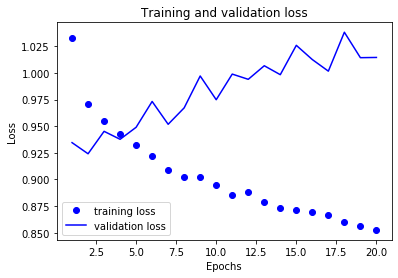

In [0]:
plt.plot(epochs, average_loss_history_RS, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_RS, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy RandomSearch

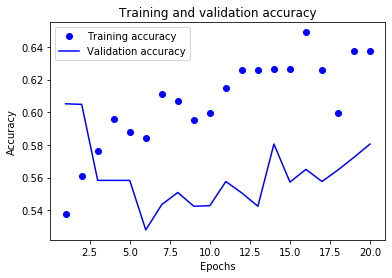

In [0]:
plt.plot(epochs, average_acc_history_RS, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_RS, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

#Plot Hyperband

##Plotting training and validation loss Hyperband

---



In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_Hb = [np.mean([x[i] for x in all_acc_histories_Hb]) for i in range(num_epochs)]
average_loss_history_Hb = [np.mean([x[i] for x in all_loss_histories_Hb]) for i in range(num_epochs)]
average_val_acc_history_Hb = [np.mean([x[i] for x in all_val_acc_histories_Hb]) for i in range(num_epochs)]
average_val_loss_history_Hb = [np.mean([x[i] for x in all_val_loss_histories_Hb]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

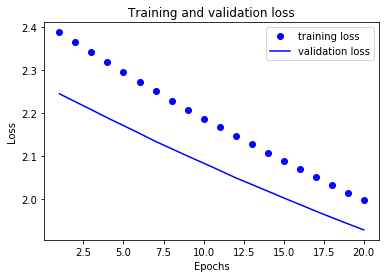

In [0]:
plt.plot(epochs, average_loss_history_Hb, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_Hb, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy Hyperband

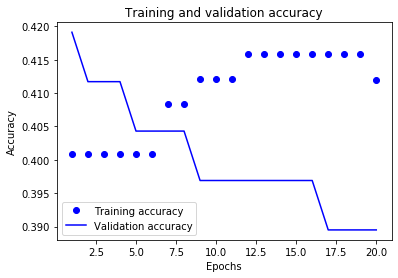

In [0]:
plt.plot(epochs, average_acc_history_Hb, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_Hb, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 